# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [ ]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    l_r = tf.placeholder(tf.float32, name='l_r')

    return input_real, input_z, l_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [ ]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
#         print(images.shape)
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        crelu1 = tf.maximum(alpha * conv1, conv1)
#         print(crelu1.shape)
        
        conv2 = tf.layers.conv2d(crelu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        crelu2 = tf.maximum(alpha * bn2, bn2)
#         print(crelu2.shape)
        
        conv3 = tf.layers.conv2d(crelu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        crelu3 = tf.maximum(alpha * bn3, bn3)
#         print(crelu3.shape)
        
        flat = tf.reshape(crelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
#         print(logits.shape)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        reshape1 = tf.reshape(x1, (-1, 7, 7, 256))
        crelu1 = tf.maximum(alpha * reshape1, reshape1)
        # 7x7x256
#         print(crelu1.shape)

        conv2 = tf.layers.conv2d_transpose(crelu1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        crelu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
#         print(crelu2.shape)
        
        conv3 = tf.layers.conv2d_transpose(crelu2, 64, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        crelu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x64
#         print(crelu3.shape)

        conv4 = tf.layers.conv2d_transpose(crelu3, 32, 5, strides=1, padding="same")
        bn4 = tf.layers.batch_normalization(conv4, training=is_train)
        crelu4 = tf.maximum(alpha * bn4, bn4)
        
        logits = tf.layers.conv2d_transpose(crelu4, out_channel_dim, 5, strides=1, padding="same")
        # 28x28xout_dim
#         print(logits.shape)
#         print(out_channel_dim)

    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    _, image_width, image_height, image_channels = data_shape
        
    input_real, input_z, l_r = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
  
    
    # TODO: Build Model
    saver = tf.train.Saver()
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                
                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                    
        show_generator_output(sess, 50, input_z, image_channels, data_image_mode)        
        saver.save(sess, './checkpoints/generator.ckpt')        
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 0.3775
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.6748
Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 1.2148
Epoch 1/2... Discriminator Loss: 1.0499... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 1.5500
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.4054
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.7098


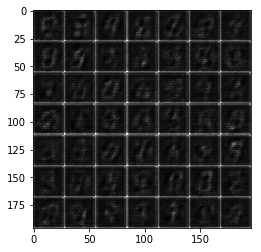

Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 1.8718
Epoch 1/2... Discriminator Loss: 0.9344... Generator Loss: 1.5941
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.4379
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.4169
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 0.7513... Generator Loss: 2.0789


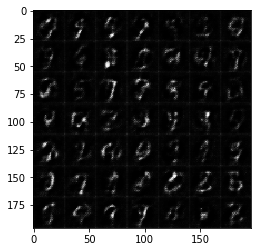

Epoch 1/2... Discriminator Loss: 1.2403... Generator Loss: 0.4967
Epoch 1/2... Discriminator Loss: 0.7528... Generator Loss: 1.1907
Epoch 1/2... Discriminator Loss: 0.7877... Generator Loss: 1.1162
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 1.5858
Epoch 1/2... Discriminator Loss: 0.6796... Generator Loss: 1.1368
Epoch 1/2... Discriminator Loss: 0.8054... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 1.5307
Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 0.5290


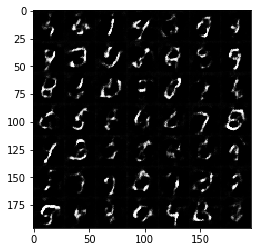

Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.6935
Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 2.1102
Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 1.6941
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 2.1435
Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 1.2496
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 1.7065
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 1.2083
Epoch 1/2... Discriminator Loss: 1.0102... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 1.4370
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 0.8059


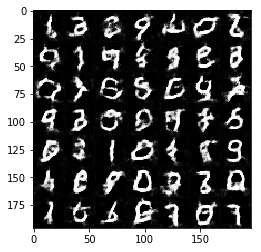

Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 0.9177
Epoch 1/2... Discriminator Loss: 0.9358... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.2931
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 1.1594
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.6331
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.0203
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.5511
Epoch 2/2... Discriminator Loss: 1.0344... Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.4807


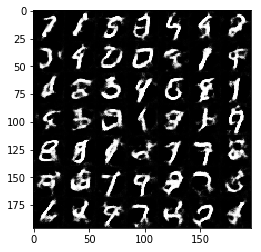

Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.7545
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.5069
Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 1.3970
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.1398
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 1.3453
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 0.8465
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.0039
Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 0.8171
Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 0.6401


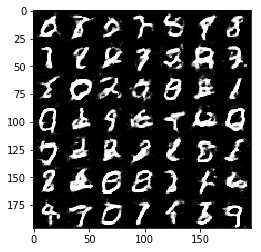

Epoch 2/2... Discriminator Loss: 0.7662... Generator Loss: 1.1989
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 1.7002
Epoch 2/2... Discriminator Loss: 1.1190... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 0.7580... Generator Loss: 1.3083
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 0.9101
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.1416
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 1.5386
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 0.7850


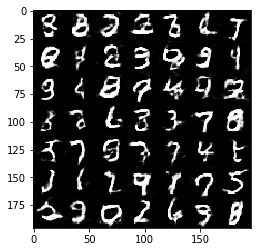

Epoch 2/2... Discriminator Loss: 0.7861... Generator Loss: 1.3521
Epoch 2/2... Discriminator Loss: 0.7805... Generator Loss: 1.8004
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.4882
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 0.9290
Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 1.8339... Generator Loss: 2.6324
Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 1.2813
Epoch 2/2... Discriminator Loss: 0.7415... Generator Loss: 1.4960
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.1845
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 0.6777


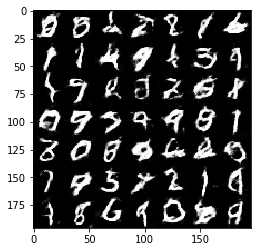

Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 0.5567
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.4834
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 1.2332
Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.1444
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.5285
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 1.4673


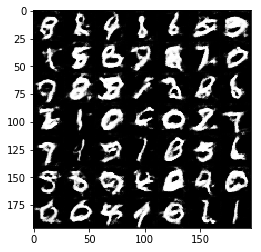

Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 0.6537... Generator Loss: 1.1390


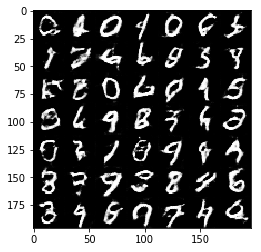

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

tf.reset_default_graph()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 0.2686... Generator Loss: 2.2794
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 8.3073
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 6.8080
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 2.6026
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 4.0630
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 2.4548


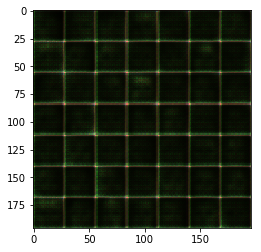

Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.4299
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.9217
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 2.1956
Epoch 1/1... Discriminator Loss: 2.0232... Generator Loss: 0.2316
Epoch 1/1... Discriminator Loss: 1.8282... Generator Loss: 0.3174
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.4912


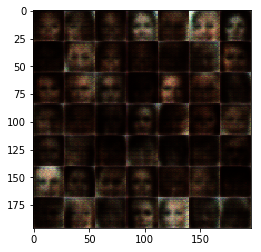

Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.3498
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 2.1981
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.9546... Generator Loss: 0.2522
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 2.2596


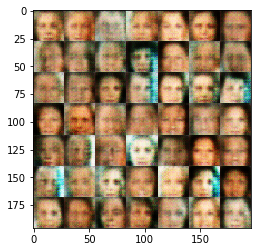

Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.8435... Generator Loss: 0.2520
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.5342
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.8690


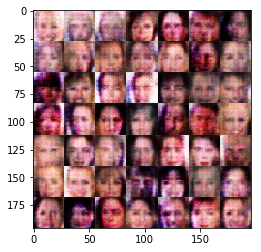

Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 2.8270
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.9264
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 2.0167
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.3562
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 3.8568
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 2.7505


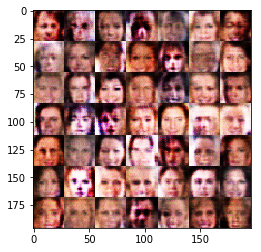

Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 2.5040
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 2.5291
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 2.7732
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 2.3198... Generator Loss: 0.1614
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 1.6762
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.6875


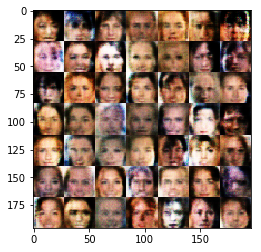

Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 5.1322
Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 4.1516
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.2681... Generator Loss: 4.9449
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 5.5593
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 0.2861... Generator Loss: 2.4749


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.